In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numdifftools as nd
from scipy.interpolate import interp1d

In [2]:
import modules.plots.real_ir as ir_plots
import modules.plots.methodological as mth_plots
import modules.experimental_rir as exprir
import modules.randomized_ir as randomized_ir
import modules.utils as utils
import modules.mcmc as mcmc

from modules_reloader import reloader
relmod = reloader(ir_plots, mth_plots, exprir, randomized_ir, utils, mcmc)

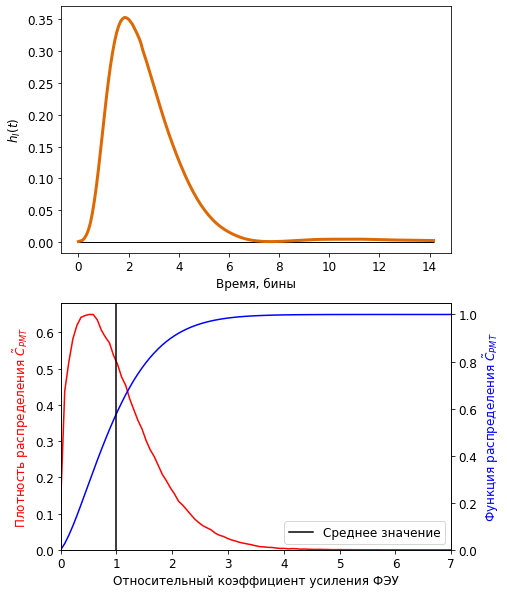

In [3]:
ir_t, ir_shape = exprir.read_ir_shape()
ir_t, ir_shape = exprir.cut_ir_shape(ir_t, ir_shape, excluded_integral_percentile=0.005)
Cpmt_values, Cpmt_pdf, Cpmt_cdf = exprir.read_C_pmt_cdf_pdf(n_sample_pts=100)

filename = 'experimental-ir-params'
f, a = ir_plots.plot_real_ir_shape_and_distribution(ir_t, ir_shape, Cpmt_values, Cpmt_pdf, Cpmt_cdf, filename=filename)

## Sanity check

Test mean (must be ~1): 0.9980501709381285


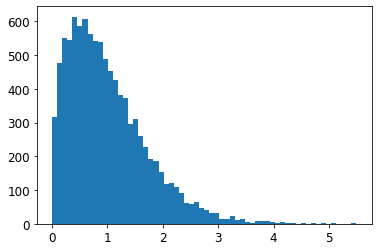

In [4]:
N_sample = 10000

C_pmt_sample = exprir.generate_C_pmt(N_sample)

print(f"Test mean (must be ~1): {C_pmt_sample.mean()}")

plt.hist(C_pmt_sample, bins=60)
plt.show()

# Пример решения задачи байесовской деконволюции с экспериментальной РИХ

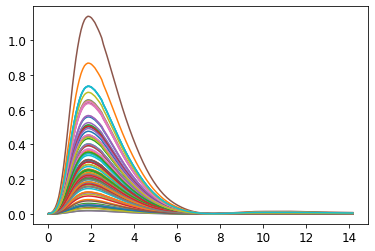

In [5]:
rir = randomized_ir.RandomizedIr(ir_x=ir_t, ir_y=ir_shape, factor=exprir.generate_C_pmt)
L = rir.L
rir.plot_realizations(count=100)

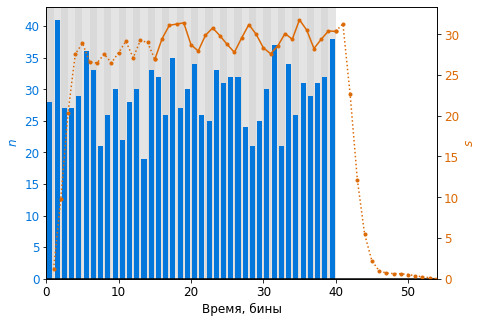

In [6]:
N = 40

n_vec_lambda = 30
n_vec = utils.generate_poissonian_ns(n_vec_lambda, N)

n_vec

s_vec = rir.convolve_with_n_vec(n_vec)

f, a = mth_plots.plot_convolution(n_vec=n_vec, s_vec=s_vec)

In [7]:
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10**6)

rireff.explore()

L=14 and N=40
RIR effects from photon in the bin #1 (t in [0; 1]):
t	effect
1	0.06 +/- 0.08
2	0.31 +/- 0.23
3	0.31 +/- 0.22
4	0.18 +/- 0.14
5	0.09 +/- 0.07
6	0.03 +/- 0.03
7	0.01 +/- 0.01
8	0.00 +/- 0.00
9	0.00 +/- 0.00
10	0.00 +/- 0.00
11	0.00 +/- 0.00
12	0.00 +/- 0.00
13	0.00 +/- 0.00
14	0.00 +/- 0.00
15	0.00 +/- 0.00

C matrix used to calculate mean-vector for a given n vector (with cut edge effects):
[[0.00039378 0.00279763 0.00336139 ... 0.         0.         0.        ]
 [0.         0.00039378 0.00279763 ... 0.         0.         0.        ]
 [0.         0.         0.00039378 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.05641499 0.         0.        ]
 [0.         0.         0.         ... 0.30518799 0.05641499 0.        ]
 [0.         0.         0.         ... 0.30624491 0.30518799 0.05641499]]

Xi matrix used to calculate covariance matrix for a given n vector:
[[ 1.30377065e-06  4.03359713e-06  5.84881068e-06  9.58028828e-06
   1.03520273

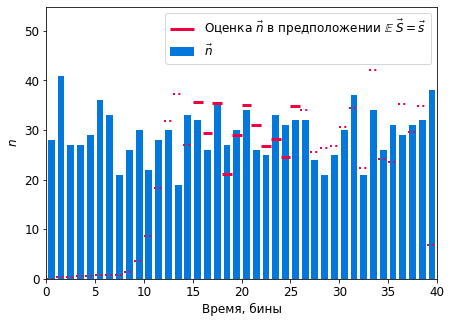

In [8]:
n_vec_estimation = rireff.estimate_n_vec(s_vec)

f, a = mth_plots.plot_mean_n_estimation(n_vec, n_vec_estimation, L)

In [12]:
# loglike = rireff.get_loglikelihood_independent_normdist(s_vec, s_vec, density=True)
# loglike(n_vec_estimation)

loglike = rireff.get_loglikelihood_mvn(s_vec, s_vec, density=True)


In [13]:
n_vec_min = np.zeros_like(n_vec_estimation, dtype=float)
n_vec_max = n_vec_estimation * 100

def logposterior(n_vec):
    if np.any(np.logical_or(n_vec < n_vec_min, n_vec > n_vec_max)):
        return - np.inf
    return loglike(n_vec)

In [14]:
result = mcmc.run_mcmc(
    logposterior,
    n_vec_estimation,
    L,
    config=mcmc.SamplingConfig(
        progress_bar=True,
        n_samples=10000,
        n_walkers=512,
        debug_acceptance_fraction_each=1000,
        autocorr_estimation_each=1000,
        multiprocessing=True,
    )
)


  0%|          | 0/10000 [00:00<?, ?it/s]/home/njvh/Documents/Science/sphere/thesis/thenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|▉         | 999/10000 [01:51<16:58,  8.84it/s]
 Current acc. frac.:0.0805
 20%|██        | 2000/10000 [03:53<13:19, 10.01it/s]
 Current acc. frac.:0.1195
 30%|███       | 3000/10000 [05:56<14:13,  8.20it/s]
 Current acc. frac.:0.12233333333333334
 40%|████      | 4000/10000 [07:58<10:11,  9.81it/s]
 Current acc. frac.:0.118875
 50%|█████     | 5000/10000 [09:51<09:14,  9.02it/s]
 Current acc. frac.:0.11649999999999999
 60%|█████▉    | 5999/10000 [11:48<05:40, 11.76it/s]
 Current acc. frac.:0.11416666666666667
 70%|███████   | 7000/10000 [13:44<05:02,  9.93it/s]
 Current acc. frac.:0.1125
 80%|███████▉  | 7999/10000 [15:47<03:25,  9.72it/s]
 Current acc. frac.:0.11106250000000001
 90%|████████▉ | 8999/10000 [17:49<01:38, 10.15it/s]
 Current

In [36]:
sample = mcmc.extract_independent_sample(result.sampler, max_sample_size=3000)

N/50 = 200;
tau: [ 862.57815319  893.57396983  893.42306545 1027.94531759 1046.53985282
 1075.7551102  1014.69896052 1033.76285878 1135.91912071 1103.5009218
  962.69486281  831.75072339  890.00537952  984.53770667 1046.34369187
  921.02719656  837.28354731  848.57178974  841.3036211   821.18830873
  819.49373607  814.9449046   813.14294618  845.39955001  835.47245837
  864.05010944  830.19609825  826.06934166  833.13145713  807.96619059
  822.98757615  821.77928201  820.86849557  831.4814065   837.77410723
  811.72288061  828.72819066  899.76485855 1087.18826675 1118.51949469]
4259 7729 10000


In [39]:
sample.shape

(2560, 40)

In [40]:
relmod()

/home/njvh/Documents/Science/sphere/thesis/modules/plots/methodological.py:183: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(pcm_X, pcm_Y, pcm_C, shading='flat', edgecolors=[''], cmap=bin_hists_cm, antialiased=True)


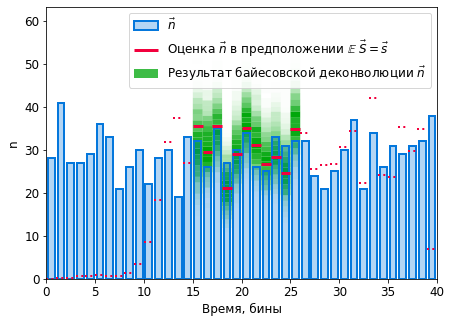

In [41]:
filename = 'bayesian-deconvolution-with-experimantal-rir'
f, a = mth_plots.plot_bayesian_mean_estimation(n_vec, sample, L, n_vec_estimation, filename=filename)